## Nolan Roth

## Investigation of String and Waveform Mechanics

## PROJECT 03

While many introductory physics courses dive into the mechanics of sound, waves, and propogation of such things on a string, creating simulations to visualize these behaviors is easier said than done. In this book, I take a look into the mechanics of a wave moving along a string with only one fixed end.

Some benchmarks to understanding this simulation:

-What are the boundary conditions? How do they contribute to the behavior we see?

-Does a Gaussian reflecting off the free end invert?

-What are the normal modes of this system?

By the end, I hope to demonstrate the behavior of a string with one free end as it is plucked from the center.

Let's begin!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ode
from scipy.optimize import curve_fit
from scipy.linalg import eigh

In [4]:
from IPython.display import HTML

def playVideo(path):
    return HTML("""
                <video width="320" height="240" controls>
                  <source src="{}" type="video/mp4">
                </video>
                """.format(path))

In [5]:
from mplEasyAnimate import animation
from tqdm import tqdm

## GAUSSIAN REFLECTION

Let's start with simulating the motion of a gausian on the string. The first thing we need to solve for is the wave motion.

With no external load, the displacement of a string at location $x$ and time $t$ is given by

$$F_T\frac{\partial u^2(x,t)}{\partial x^2}=\rho \frac{\partial u^2(x,t)}{\partial t^2}$$

where $F_T$ is the tension and $\rho$ is the linaer density $M/L$ of the string.  This can be written

$$\frac{\partial u^2(x,t)}{\partial x^2}= \frac{1}{v^2} \frac{\partial u^2(x,t)}{\partial t^2}$$

where $v=\sqrt{F_T/\rho}$.

Moving from this basis, we can take the direction of the Finite Difference Method (FDM). This utilizes the displacement of each particle from equilibrium based on some given force or function.

Write each second derivative using FDM approximation. The second order approximation of the second partial derivative with respect to $x$ is

$$\frac{\partial u^2(x,t)}{\partial x^2} \approx \frac{u(x+h,t)-2u(x,t)+u(x-h,t)}{h^2}$$

The second order approximation of the second partial derivative with respect to $t$ is

$$\frac{\partial u^2(x,t)}{\partial t^2} \approx \frac{u(x,t+\Delta t)-2u(x,t)+u(x,t-\Delta t)}{\Delta t^2}$$

Use the subscript $m$ to indicate the $m^{th}$ index of the grid position $x_m$. Use the superscript $n$ to indicate the $n^{th}$ step in time. Then the wave equation is

$$\frac{u(x+h,t)-2u(x,t)+u(x-h,t)}{h^2} = \frac{1}{v^2} \frac{u(x,t+\Delta t)-2u(x,t)+u(x,t-\Delta t)}{\Delta t^2}$$

$$\frac{u_{m-1}^n-2u_{m}^n+u_{m+1}^n}{h^2} = \frac{1}{v^2} \frac{u_{m}^{n-1}-2u_{m}^n+u_{m}^{n+1}}{\Delta t^2} $$


The indices with $m$ represent grid points. The superscripts with $n$ are the evolution in time. The goal is to step forward in time. Thus, solve for $u_{m}^{n+1}$.

$$u_{m}^{n+1} = 2(1-\beta^2)u_m^n - u_m^{n-1} + \beta^2(u_{m-1}^n+u_{m+1}^n)$$

where $\beta=\frac{v\Delta t}{h}$. To evolve in time, we use two arrays to hold the solutions to $u(x)$ at all grid points at times $t_{n-1}$ and $t_n$, advance the solution to $t_{n+1}$ and store it in a third array, then swap the appropriate arrays to advance to $t_{n+2}$, and so on.

In [6]:
def wavemotion(u0, u1):
    u2 = 2*(1-b)*u1 - u0                   # unshifted terms 
    u2[1:-1] += b*( u1[0:-2] + u1[2:] )      # left, right 
    return u2

def gaussian(x):
    return np.exp(-(x-5)**2)


In this next cell, the wavemotion is integrated in the bottom for loop. In that loop, we set
$$u2[N] = u2[N-1]$$

Which explicitely sets the rightmost point of the string equal to the displacement of the second to right most point on the string, rather than the last point being hardcoded to 0 displacement. This "frees" that end of the string!

The rest of the cell is walking through the initialization of the string's displacement matrices.

In [7]:
L, N = 10, 100           # length of string, number of intervals
b = 1.0                    # beta^2

t_total = 20
N_t = 200 #number of time intervals
dt = t_total/N_t
t = 0
ta = np.linspace(0,t_total,N_t+1)

x = np.linspace(0, L, N+1)
u0, u1 = gaussian(x), gaussian(x)

data = np.zeros((N_t+1,N+1))  #columns are u at grid points
data[0]=u0
data[1]=u1

for i in range(N_t):
    u2 = wavemotion(u0, u1)
    u2[N]=u2[N-1]  #### this is the only new line
    u0, u1 = u1, u2
    data[i]=u2

This next function is used to animate the string.

In [8]:
def easyanimate_string(t_array, u_array, filename):
    xa = np.linspace(0., L, N+1)

    t_offsets = t_array
    anim = animation(filename)
    i=0
    for offset in tqdm(t_offsets):
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        ax.plot(xa, u_array[i,:])
        ax.set_xlim(0,L)
        ax.set_ylim(-1.1,1.1)
        
        anim.add_frame(fig)
        plt.close(fig)
        i=i+1
    anim.close()    

In [9]:
file='string.mp4'
easyanimate_string(ta,data,file)

100%|██████████| 201/201 [00:33<00:00,  6.01it/s]


When the string is animated, you can see the boundary behavior of the gaussian on the right side--instead of reflecting and inverting like the left side, the wave simply rebounds.

In [10]:
playVideo(file)

While the previous video essentially showed a string plucked in a gaussian shape, the next block shows a gaussian given a horizontal velocity along the string. This change comes from the initializations of u0 and u1. Previously, both were set to be equivilant gaussian functions. Now, u1 is given some initial displacement from u0.

In [11]:
L, N = 10, 100           # length of string, number of intervals
b = 1.0                    # beta^2
h = L/N

t_total = 20
N_t = 200 #number of time intervals
dt = t_total/N_t
t = 0
ta = np.linspace(0,t_total,N_t+1)

x = np.linspace(0, L, N+1)
u0 = gaussian(x)
u1 = gaussian(x-b*h)

data = np.zeros((N_t+1,N+1))  #columns are u at grid points
data[0]=u0
data[1]=u1

for i in range(N_t):
    u2 = wavemotion(u0, u1)
    u2[N]=u2[N-1]  #### this is the only new line
    u0, u1 = u1, u2
    data[i]=u2

data.shape


(201, 101)

In [12]:
file='string-2.mp4'
easyanimate_string(ta,data,file)

100%|██████████| 201/201 [00:31<00:00,  6.37it/s]


The reflection can also be seen in the following video, where the wave is given an initial velocity towards the open-end at the right. The wave reflects off that end, but only inverts when reflecting off the fixed end at the left.

In [13]:
playVideo(file)

## NORMAL MODES

In considering the motion of waves, we can also look at normal modes! The normal modes here were plotted using a method building off of the eigen modes and eigen frequencies of displacement matrices.

Let's start with a small example: For three masses connected by four springs and two walls at the boundaries, the equations of motion for the displacement $u_i$ for each mass $m_i$ are:

$$m_1\ddot{u}_1 = -ku_1-k(u_1-u_2)=-2ku_1+ku_2$$

$$m_2\ddot{u}_2 = -k(u_2-u_1)-k(u_2-u_3)=ku_1-2ku_2+ku_3$$

$$m_3\ddot{u}_3 = -k(u_3-u_2)-ku_3=ku_2-2ku_3$$

Let's assume the masses oscillate vertically. In this case $k=F_T/L_0$ where $F_T$ is the tension in the "string" and $L_0$ is the nominal distance between masses ("atoms").

Suppose that there is a set of initial conditions that results in motion where each mass oscillates with a frequency $\omega$ and the displacement of each mass $m_i$ is described by a single sinusoidal function:

$$u_i = a_i \cos(\omega t + \phi)$$

Substituting this into the differential equations above gives:

$$2ka_1-ka_2 + 0 = m_1\omega^2a_1$$

$$-ka_1+2ka_2 - ka_3 = m_2\omega^2a_2$$

$$0 -ka_2 + 2ka_3 = m_3\omega^2a_3$$

It is written in this way to make it more obvious that we can express these equations with matrices.

$$
\left[ {\begin{array}{ccc}
   2k & -k & 0 \\
   -k & 2k & -k \\
   0 & -k & 2k \\
  \end{array} } \right]
\left[ {\begin{array}{c}
    a_1 \\
    a_2 \\
    a_3 \\
  \end{array} } \right]
  = \omega^2
\left[ {\begin{array}{ccc}
   m_1 & 0 & 0 \\
   0 & m_2 & 0 \\
   0 & 0 & m_3 \\
  \end{array} } \right]
\left[ {\begin{array}{c}
    a_1 \\
    a_2 \\
    a_3 \\
  \end{array} } \right]
$$

Define $\lambda=\omega^2$, then

$$[A-\lambda B]\vec{a}$$

where $\lambda$ is called the eigenvalue and $\vec{a}$ is called the eigenvector. To find the frequencies, solve for the eigenvalues using

$$\det\left[ A-\lambda B\right]=0$$

$$\left | {\begin{array}{ccc}
   2k-\lambda m_1 & -k & 0 \\
   -k & 2k-\lambda m_2 & -k \\
   0 & -k & 2k-\lambda m_3 \\
  \end{array} } \right |$$
  
There are three eigenvalues. Substitute each eigenvalue back into the equations of motion above and solve for its corresponding eigenvector:

$$ \vec{a}=
\left[ {\begin{array}{c}
    a_1 \\
    a_2 \\
    a_3 \\
  \end{array} } \right]
$$

Write the general analytic solution for the triatomic molecule as a sum of the normal modes.

$$
\left[ {\begin{array}{c}
    u_1 \\
    u_2 \\
    u_3 \\
  \end{array} } \right]
  = A_0
\left[ {\begin{array}{c}
    a_{00} \\
    a_{10} \\
    a_{20} \\
  \end{array} } \right]
  \cos(\omega_0t + \phi_0)
+ A_1
\left[ {\begin{array}{c}
    a_{01} \\
    a_{11} \\
    a_{21} \\
  \end{array} } \right]
  \cos(\omega_1t + \phi_1)
+ A_2
\left[ {\begin{array}{c}
    a_{02} \\
    a_{12} \\
    a_{22} \\
  \end{array} } \right]
  \cos(\omega_1t + \phi_2)
$$

The constants $A_0,\ A_1,\ A_2, \phi_0,\ \phi_1,\ \phi_2$ depend on the initial conditions of the atoms.

First, let's set the initial velocities of all atoms to zero so the phases are zero.


Now, let's solve for $A_0,\ A_1,\ A_2$ based on the initial positions of the atoms. At $t=0$, 

$$u_1=u_{1i}=A_0a_{00} + A_1a_{01} + A_2a_{02}$$

$$u_2=u_{2i}=A_0a_{10} + A_1a_{11} + A_2a_{12}$$

$$u_3=u_{3i}=A_0a_{20} + A_1a_{21} + A_2a_{22}$$

We have three equations and three unknowns. Use linear algebra.

$$
\left[ {\begin{array}{ccc}
   a_{00} & a_{01} & a_{02} \\
   a_{10} & a_{11} & a_{22} \\
   a_{20} & a_{21} & a_{22} \\
  \end{array} } \right]
\left[ {\begin{array}{c}
    A_0 \\
    A_1 \\
    A_2 \\
  \end{array} } \right]
  = 
\left[ {\begin{array}{c}
    u_{1i} \\
    u_{2i} \\
    u_{3i} \\
  \end{array} } \right]
$$

The numpy function `numpy.linalg.solve()` will solve this equation and return the coefficients:

$$
\left[ {\begin{array}{c}
    A_0 \\
    A_1 \\
    A_2 \\
  \end{array} } \right]
$$

The right boundary was freed by removing a coefficient term in the last position in the matrix originally representing the "fixed mass" of a wall. This simple change greatly effects the behavior of the string!

In [17]:
def normal_modes(Natoms, ks, mass, ui, udoti, t_total):
    global N, k, m
    N=Natoms
    k=ks
    m=mass
    
    #Build matrices
    A=np.zeros((Natoms,Natoms))

    for i in range(Natoms):
        A[i,i] = 2*ks
        if i==0:
            A[0,i+1]=-ks
        elif i==Natoms-1:
            A[i,i-1]=-ks
        else:
            A[i,i-1]=-ks
            A[i,i+1]=-ks

    #Define our second boundary condition to be free rather than fixed
    A[Natoms-1,Natoms-1] = ks
    
    B=mass*np.identity(Natoms)

    #find eigenvalues and eigenvectors
    lamb, a = eigh(A, B)        # eigenvalues and eigenvectors  
    #print("eigenvalues (omega^2):", lamb)
    #print("eigenvectors are column vectors in:\n\n", a)

    #Find coefficients for normal modes
    Acoeffs = np.linalg.solve(a,ui)

    #build the general solution
    t = np.linspace(0,t_total,1000)

    omegas = np.sqrt(lamb)
    u_atoms = np.zeros((Natoms,len(t)))

    for i in range(Natoms):
        for w in range(0,len(omegas)):
            u_atoms[i] = u_atoms[i] + Acoeffs[w]*a[i,w]*np.cos(omegas[w]*t)

    return omegas, a, u_atoms, t

With the above function giving us our normal modes, we need the function below to plot them.

In [18]:
def plot_mode_teq0(mode, freqs, vecs): #plot normal mode at t=0
    
    u_mode = vecs[:,mode]
    u_mode_with_boundary=np.insert(u_mode,0,0) #add 0 to beginning of array
    #u_mode_with_boundary=np.append(u_mode_with_boundary,0) #add 0 to end of array
    xa = np.linspace(0,L,Natoms+1)
        
    plt.figure()
    plt.title("normal mode %d" % mode)
    plt.plot(xa,u_mode_with_boundary, 'b-', label='u_i')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend(loc='lower right')
    plt.show()


Let's calculate and plot the first five normal modes.

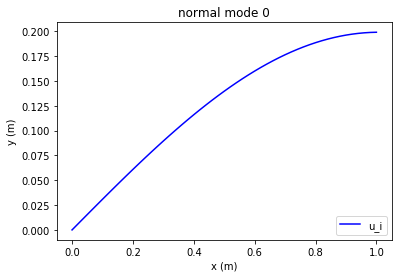

In [19]:
Natoms = 50
ks = 1
mass = 1
L = 1
L0 = L/(Natoms+1)
F_T = ks*L0
t_tot = 10*np.pi

u_i = np.zeros(Natoms)
udot_i = np.zeros(Natoms)

eig_freq, eig_vec, u, ta = normal_modes(Natoms, ks, mass, u_i, udot_i, t_tot)
plot_mode_teq0(0,eig_freq,eig_vec)

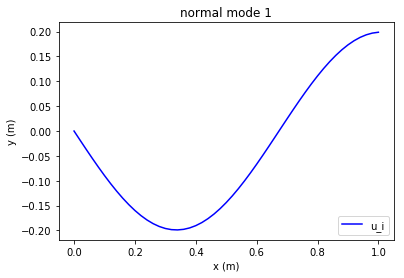

In [20]:
plot_mode_teq0(1,eig_freq,eig_vec)

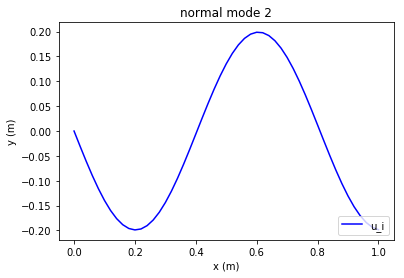

In [21]:
plot_mode_teq0(2,eig_freq,eig_vec)

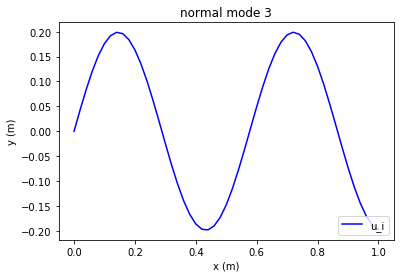

In [22]:
plot_mode_teq0(3,eig_freq,eig_vec)

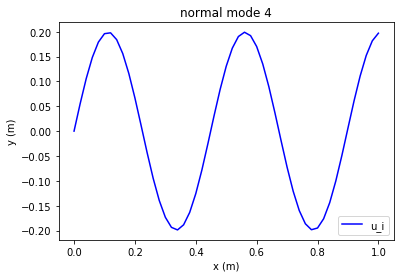

In [23]:
plot_mode_teq0(4,eig_freq,eig_vec)

## PLUCKING A STRING THAT IS FREE AT ONE END

Another interesting simulation to show the properties of a string with a free end is to pluck it in the center. The following cell block sets up a string in a "tent" form--plucked in the center so that the string on either side of the center is pulled taut.

This is all done using the FDM method used earlier in this notebook. Thus, the free end is created by adding the line:

$$u2[N] = u2[N-1]$$

while we integrate.

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]
(201, 101)


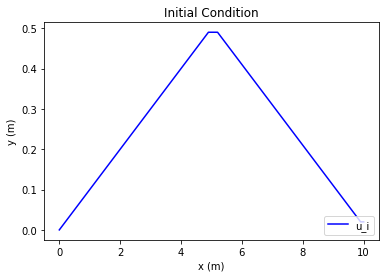

In [24]:
L, N = 10, 100           # length of string, number of intervals
b = 1.0                    # beta^2
h = L/N

t_total = 20
N_t = 200 #number of time intervals
dt = t_total/N_t
t = 0
ta = np.linspace(0,t_total,N_t+1)

A = 0.5
lamb = 1*L
v = b*h/dt
f = v/lamb
k=2*np.pi/lamb

x = np.linspace(0, L, N+1)
print(x)
u0 = np.zeros(N+1)
u0[:51] = .1*x[(x<=5)]
u0[51:] = (-.1*x[(x<5)])+0.5
u1 = u0

data = np.zeros((N_t+1,N+1))  #columns are u at grid points
data[0]=u0
data[1]=u1

for i in range(N_t):
    u2 = wavemotion(u0, u1)
    u2[N]=u2[N-1]  #### this is the only new line
    u0, u1 = u1, u2
    data[i]=u2

print(data.shape)

plt.figure()
plt.title("Initial Condition")
plt.plot(x,data[0,:], 'b-', label='u_i')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(loc='lower right')
plt.show()


In [25]:
file='string-tent.mp4'
easyanimate_string(ta,data,file)

100%|██████████| 201/201 [00:30<00:00,  6.49it/s]


In [26]:
playVideo(file)

The wave exhibits some pretty strange behavior! Because the initial conditions were angular instead of the soft shapes of sinusoids or gaussians, the wave itself propogated in a sharp, angular fashion!

This concludes my investigation into this area of string behavior. I covered a number of benchmarks in understanding this system:

-I explained the change in boundary condidtions and how they contributed to the behavior of the string.

-I found that a gaussian reflecting of the free end of the string does not invert!

-I plotted the first five normal modes of the system using a method based in solving for the eigenvalues and eigenfrequencies of the oscillating system.

Additionally, I demonstrated the behavior of a string with one free end as it was plucked from the center.
